# von Mises plasticity

![Shows the von Mises stress distribution in a cantilever beam.](plasticity.png)
*Figure 1.* A coarse mesh solution of a cantilever beam subjected to a load
causing plastic deformations. The initial yield limit is 200 MPa but due to
hardening it increases up to approximately 240 MPa.

## Introduction

This example illustrates the use of a nonlinear material model in JuAFEM.
The particular model is von Mises plasticity (also know as J₂-plasticity) with
isotropic hardening. The model is fully 3D, meaning that no assumptions like *plane stress*
or *plane strain* are introduced.

Also note that the theory of the model is not described here, instead one is
referred to standard textbooks on material modeling.

To illustrate the use of the plasticity model, we setup and solve a FE-problem
consisting of a cantilever beam loaded at its free end. But first, we shortly
describe the parts of the implementation deadling with the material modeling.

## Material modeling
This section describes the `struct`s and methods used to implement the material
model

### Material parameters and state variables

Start by loading some necessary packages

In [1]:
using JuAFEM, SparseArrays, LinearAlgebra, Printf

We define a J₂-plasticity-material, containing material parameters and the elastic
stiffness Dᵉ (since it is constant)

In [2]:
struct J2Plasticity{T, S <: SymmetricTensor{4, 3, T}}
    G::T  # Shear modulus
    K::T  # Bulk modulus
    σ₀::T # Initial yield limit
    H::T  # Hardening modulus
    Dᵉ::S # Elastic stiffness tensor
end;

Next, we define a constructor for the material instance.

In [3]:
function J2Plasticity(E, ν, σ₀, H)
    δ(i,j) = i == j ? 1.0 : 0.0 # helper function
    G = E / 2(1 + ν)
    K = E / 3(1 - 2ν)

    Isymdev(i,j,k,l) = 0.5*(δ(i,k)*δ(j,l) + δ(i,l)*δ(j,k)) - 1.0/3.0*δ(i,j)*δ(k,l)
    temp(i,j,k,l) = 2.0G *( 0.5*(δ(i,k)*δ(j,l) + δ(i,l)*δ(j,k)) + ν/(1.0-2.0ν)*δ(i,j)*δ(k,l))
    Dᵉ = SymmetricTensor{4, 3}(temp)
    return J2Plasticity(G, K, σ₀, H, Dᵉ)
end;

Define a `struct` to store the material state.

In [4]:
mutable struct MaterialState{T, S <: SecondOrderTensor{3, T}}
    # Store "converged" values
    ϵᵖ::S # plastic strain
    σ::S # stress
    k::T # hardening variable

    # Store temporary values used during equilibrium iterations
    temp_ϵᵖ::S
    temp_σ::S
    temp_k::T
end

Constructor for initializing a material state. Every quantity is set to zero.

In [5]:
function MaterialState()
    return MaterialState(
                zero(SymmetricTensor{2, 3}),
                zero(SymmetricTensor{2, 3}),
                0.0,
                zero(SymmetricTensor{2, 3}),
                zero(SymmetricTensor{2, 3}),
                0.0)
end

Main.##264.MaterialState

Next, we define a method to update the material state after equilibrium has
been found. This will be called at the end of each time-step.

In [6]:
function update_state!(state::MaterialState)
    state.ϵᵖ = state.temp_ϵᵖ
    state.σ = state.temp_σ
    state.k = state.temp_k
end;

For later use, during the post-processing step, we define a function to
compute the von Mises effective stress.

In [7]:
function vonMises(σ)
    s = dev(σ)
    return sqrt(3.0/2.0 * s ⊡ s)
end;

## Constitutive driver

This is the actual method which computes the stress and material tangent
stiffness in a given integration point.
Input is the current strain and material state.

In [8]:
function compute_stress_tangent(ϵ::SymmetricTensor{2, 3}, material::J2Plasticity, state::MaterialState)
    # unpack some material parameters
    G = material.G
    K = material.K
    H = material.H

    # We use (•)ᵗ to denote *trial*-values
    σᵗ = material.Dᵉ ⊡ (ϵ - state.ϵᵖ) # trial-stress
    sᵗ = dev(σᵗ)         # deviatoric part of trial-stress
    J₂ = 0.5 * sᵗ ⊡ sᵗ   # second invariant of sᵗ
    σᵗₑ = sqrt(3.0*J₂)   # effetive trial-stress (von Mises stress)
    σʸ = material.σ₀ + H * state.k # Previous yield limit

    φᵗ  = σᵗₑ - σʸ # Trial-value of the yield surface

    if φᵗ < 0.0 # elastic loading
        state.temp_σ = σᵗ
        return state.temp_σ, material.Dᵉ
    else # plastic loading
        h = H + 3G
        μ =  φᵗ / h   # plastic multiplier

        c1 = 1 - 3G * μ / σᵗₑ
        s = c1 * sᵗ           # updated deviatoric stress
        σ = s + vol(σᵗ)       # updated stress

        # Compute algorithmic tangent stiffness ``D = \frac{\Delta \sigma }{\Delta \epsilon}``
        κ = H * (state.k + μ) # drag stress
        σₑ = material.σ₀ + κ  # updated yield surface

        δ(i,j) = i == j ? 1.0 : 0.0
        Isymdev(i,j,k,l)  = 0.5*(δ(i,k)*δ(j,l) + δ(i,l)*δ(j,k)) - 1.0/3.0*δ(i,j)*δ(k,l)
        Q(i,j,k,l) = Isymdev(i,j,k,l) - 3.0 / (2.0*σₑ^2) * s[i,j]*s[k,l]
        b = (3G*μ/σₑ) / (1.0 + 3G*μ/σₑ)

        Dtemp(i,j,k,l) = -2G*b * Q(i,j,k,l) - 9G^2 / (h*σₑ^2) * s[i,j]*s[k,l]
        D = material.Dᵉ + SymmetricTensor{4, 3}(Dtemp)

        # Store outputs in the material state
        Δϵᵖ = 3/2 *μ / σₑ*s            # plastic strain
        state.temp_ϵᵖ = state.ϵᵖ + Δϵᵖ  # plastic strain
        state.temp_k = state.k + μ     # hardening variable
        state.temp_σ = σ               # updated stress
        return state.temp_σ, D
    end
end

compute_stress_tangent (generic function with 1 method)

## FE-problem
What follows are methods for assembling and and solving the FE-problem.

In [9]:
function create_values(interpolation)
    # setup quadrature rules
    qr      = QuadratureRule{3,RefTetrahedron}(2)
    face_qr = QuadratureRule{2,RefTetrahedron}(3)

    # create geometric interpolation (use the same as for u)
    interpolation_geom = Lagrange{3,RefTetrahedron,1}()

    # cell and facevalues for u
    cellvalues_u = CellVectorValues(qr, interpolation, interpolation_geom)
    facevalues_u = FaceVectorValues(face_qr, interpolation, interpolation_geom)

    return cellvalues_u, facevalues_u
end;

### Add degrees of freedom

In [10]:
function create_dofhandler(grid, interpolation)
    dh = DofHandler(grid)
    dim = 3
    push!(dh, :u, dim, interpolation) # add a displacement field with 3 components
    close!(dh)
    return dh
end

create_dofhandler (generic function with 1 method)

### Boundary conditions

In [11]:
function create_bc(dh, grid)
    dbcs = ConstraintHandler(dh)
    # Clamped on the left side
    dofs = [1, 2, 3]
    dbc = Dirichlet(:u, getfaceset(grid, "left"), (x,t) -> [0.0, 0.0, 0.0], dofs)
    add!(dbcs, dbc)
    close!(dbcs)
    return dbcs
end;

### Assembling of element contributions

* Residual vector `r`
* Tangent stiffness `K`

In [12]:
function doassemble(cellvalues::CellVectorValues{dim},
                    facevalues::FaceVectorValues{dim}, K::SparseMatrixCSC, grid::Grid,
                    dh::DofHandler, material::J2Plasticity, u, states, t) where {dim}
    r = zeros(ndofs(dh))
    assembler = start_assemble(K, r)
    nu = getnbasefunctions(cellvalues)
    re = zeros(nu)     # element residual vector
    ke = zeros(nu, nu) # element tangent matrix

    for (cell, state) in zip(CellIterator(dh), states)
        fill!(ke, 0)
        fill!(re, 0)
        eldofs = celldofs(cell)
        ue = u[eldofs]
        assemble_cell!(ke, re, cell, cellvalues, facevalues, grid, material,
                       ue, state, t)
        assemble!(assembler, eldofs, re, ke)
    end
    return K, r
end

doassemble (generic function with 1 method)

Compute element contribution to the residual and the tangent.

In [13]:
function assemble_cell!(Ke, re, cell, cellvalues, facevalues, grid, material,
                        ue, state, t)
    n_basefuncs = getnbasefunctions(cellvalues)
    reinit!(cellvalues, cell)

    for q_point in 1:getnquadpoints(cellvalues)
        # For each integration point, compute stress and material stiffness
        ∇u = function_gradient(cellvalues, q_point, ue)
        ϵ = symmetric(∇u) # Total strain
        σ, D = compute_stress_tangent(ϵ, material, state[q_point])

        dΩ = getdetJdV(cellvalues, q_point)
        for i in 1:n_basefuncs
            δϵ = symmetric(shape_gradient(cellvalues, q_point, i))

            re[i] += (δϵ ⊡ σ) * dΩ # add internal force to residual
            for j in 1:i
                Δϵ = symmetric(shape_gradient(cellvalues, q_point, j))
                Ke[i, j] += δϵ ⊡ D ⊡ Δϵ * dΩ
            end
        end
    end
    symmetrize_lower!(Ke)

    # Add traction as a negative contribution to the element residual `re`:
    for face in 1:nfaces(cell)
        if onboundary(cell, face) && (cellid(cell), face) ∈ getfaceset(grid, "right")
            reinit!(facevalues, cell, face)
            for q_point in 1:getnquadpoints(facevalues)
                dΓ = getdetJdV(facevalues, q_point)
                for i in 1:n_basefuncs
                    δu = shape_value(facevalues, q_point, i)
                    re[i] -= (δu ⋅ t) * dΓ
                end
            end
        end
    end

end

assemble_cell! (generic function with 1 method)

Helper function to symmetrize the material tangent

In [14]:
function symmetrize_lower!(K)
    for i in 1:size(K,1)
        for j in i+1:size(K,1)
            K[i,j] = K[j,i]
        end
    end
end;

Define a function which solves the FE-problem.

In [15]:
function solve()
    # Define material parameters
    E = 200.0e9 # [Pa]
    H = E/20   # [Pa]
    ν = 0.3     # [-]
    σ₀ = 200e6  # [Pa]
    material = J2Plasticity(E, ν, σ₀, H)

    L = 10.0 # beam length [m]
    w = 1.0  # beam width [m]
    h = 1.0  # beam height[m]
    n_timesteps = 10
    u_max = zeros(n_timesteps)
    traction_magnitude = 1.e7 * range(0.5, 1.0, length=n_timesteps)

    # Create geometry, dofs and boundary conditions
    n = 2
    nels = (10n, n, 2n) # number of elements in each spatial direction
    P1 = Vec((0.0, 0.0, 0.0))  # start point for geometry
    P2 = Vec((L, w, h))        # end point for geometry
    grid = generate_grid(Tetrahedron, nels, P1, P2)
    interpolation = Lagrange{3, RefTetrahedron, 1}() # Linear tet with 3 unknowns/node

    dh = create_dofhandler(grid, interpolation) # JuaFEM helper function
    dbcs = create_bc(dh, grid) # create Dirichlet boundary-conditions

    cellvalues, facevalues = create_values(interpolation)

    # Pre-allocate solution vectors, etc.
    n_dofs = ndofs(dh)  # total number of dofs
    u  = zeros(n_dofs)  # solution vector
    Δu = zeros(n_dofs)  # displacement correction
    r = zeros(n_dofs)   # residual
    K = create_sparsity_pattern(dh); # tangent stiffness matrix

    # Create material states. One array for each cell, where each element is an array of material-
    # states - one for each integration point
    nqp = getnquadpoints(cellvalues)
    states = [[MaterialState() for _ in 1:nqp] for _ in 1:getncells(grid)]

    # states = [MaterialState() for _ in 1:nqp for _ in 1:getncells(grid)]
    # temp_states = [MaterialState() for _ in 1:nqp for _ in 1:getncells(grid)]

    # Newton-Raphson loop
    NEWTON_TOL = 1 # 1 N
    print("\n Starting Netwon iterations:\n")

    for timestep in 1:n_timesteps
        t = timestep # actual time (used for evaluating d-bndc)
        traction = Vec((0.0, 0.0, traction_magnitude[timestep]))
        newton_itr = -1
        print("\n Time step @time = $timestep:\n")
        update!(dbcs, t) # evaluates the D-bndc at time t
        apply!(u, dbcs)  # set the prescribed values in the solution vector

        while true; newton_itr += 1

            if newton_itr > 8
                error("Reached maximum Newton iterations, aborting")
                break
            end
            K, r = doassemble(cellvalues, facevalues, K, grid, dh, material, u,
                             states, traction);
            norm_r = norm(r[JuAFEM.free_dofs(dbcs)])

            print("Iteration: $newton_itr \tresidual: $(@sprintf("%.8f", norm_r))\n")
            if norm_r < NEWTON_TOL
                break
            end

            apply_zero!(K, r, dbcs)
            Δu = Symmetric(K) \ r
            u -= Δu
        end

        # Update all the material states after we have reached equilibrium
        for cell_states in states
            foreach(update_state!, cell_states)
        end
        u_max[timestep] = max(abs.(u)...) # maximum displacement in current timestep
    end

    # ## Postprocessing
    # Only a vtu-file corrsponding to the last time-step is exported.
    #
    # The following is a quick (and dirty) way of extracting average cell data for export.
    mises_values = zeros(getncells(grid))
    κ_values = zeros(getncells(grid))
    for (el, cell_states) in enumerate(states)
        for state in cell_states
            mises_values[el] += vonMises(state.σ)
            κ_values[el] += state.k*material.H
        end
        mises_values[el] /= length(cell_states) # average von Mises stress
        κ_values[el] /= length(cell_states)     # average drag stress
    end
    vtk_grid("plasticity", dh) do vtkfile
        vtk_point_data(vtkfile, dh, u) # displacement field
        vtk_cell_data(vtkfile, mises_values, "von Mises [Pa]")
        vtk_cell_data(vtkfile, κ_values, "Drag stress [Pa]")
    end

    return u_max, traction_magnitude
end

solve (generic function with 1 method)

Solve the FE-problem and for each time-step extract maximum displacement and
the corresponding traction load. Also compute the limit-traction-load

In [16]:
u_max, traction_magnitude = solve();


 Starting Netwon iterations:

 Time step @time = 1:
Iteration: 0 	residual: 1435838.41167605
Iteration: 1 	residual: 118655.22430254
Iteration: 2 	residual: 59.50456058
Iteration: 3 	residual: 0.00002568

 Time step @time = 2:
Iteration: 0 	residual: 159537.60129714
Iteration: 1 	residual: 1694313.86970214
Iteration: 2 	residual: 61777.44063568
Iteration: 3 	residual: 14.34471357
Iteration: 4 	residual: 0.00001484

 Time step @time = 3:
Iteration: 0 	residual: 159537.60129722
Iteration: 1 	residual: 3286236.01301266
Iteration: 2 	residual: 95211.71236179
Iteration: 3 	residual: 42.10281102
Iteration: 4 	residual: 0.00002034

 Time step @time = 4:
Iteration: 0 	residual: 159537.60129739
Iteration: 1 	residual: 4074584.79655473
Iteration: 2 	residual: 125522.31517769
Iteration: 3 	residual: 85.56234802
Iteration: 4 	residual: 0.00008218

 Time step @time = 5:
Iteration: 0 	residual: 159537.60129697
Iteration: 1 	residual: 4941354.67155585
Iteration: 2 	residual: 598659.61655942
Iteratio

Finally we plot the load-displacement curve.

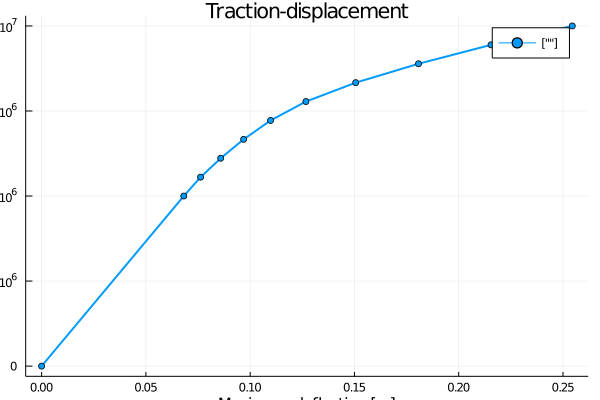

In [17]:
using Plots
plot(
    vcat(0.0, u_max),                # add the origin as a point
    vcat(0.0, traction_magnitude),
    linewidth=2,
    title="Traction-displacement",
    label=[""],
    markershape=:auto
    )
ylabel!("Traction [Pa]")
xlabel!("Maximum deflection [m]")

*Figure 2.* Load-displacement-curve for the beam, showing a clear decrease
in stiffness as more material starts to yield.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*